# Performance assessment with LONG WAVE fluxes in ARPEGE-Climat PPE

<a id="top">This code</a> is assessing model performance based on TOA Short Wave fluxes (SW) within the ARPEGE_Climat Perturbed Physics Ensemble. The metric is then used together with emulators (Multi Linear Regression) to constrain the feedback distribution in the ensemble, but also to study a subset of optimal parameter chosen with the total metric $E_{tot}$ and simulated with ARPEGE-Climat 6.3. <br> 

## It is a 6 steps method : 
### [Step 1 - EOF analysis](#EOF)
### [Step 2 - MultiLinReg predictions](#emulator)
### [Step 3 - Projection of observation dataset](#observation)
### [Step 4 - RMSE estimate](#RMSE)
### [Figure histograms](#histograms)
### [Step 5 - Optimisation](#optim)
### [Step 6 - Optimal subset of parameters](#selection)

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['rlut']
variable = 'LW'
TITLE = 'Long Wave fluxes'
ylabel = '$E_{LW}$ ($W.m^{-2}.K^{-1}$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_file_npy = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
path_file_csv = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv"
path_file_txt = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/txt"

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# <a id="EOF">Step 1 - EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_LW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    LW = df['rlut']
    
    return LW

In [6]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [8]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_LW_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_LW_xarr(path, filename, variables)

In [9]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_LW_xarr(path, filename, variables)
    i=i+1  

In [10]:
#amip['official'] = official_amip
amip['p1'] = p1_amip

### Create EOF input matrix

In [11]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [12]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray 'rlut' (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time
Attributes:
    long_name:           TOA Outgoing Longwave Radiation
    units:               W m-2
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       toa_outgoing_longwave_flux
    description:         at the top of the atmosphere (to be compared with sa...
    positive:            up
    history:             none
    cell_measures:       area: areacella

### EOF analysis

In [13]:
# Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [34]:
## --Save weights 
np.save(path_file_npy+'/W_eof_2D_'+variable+'.npy', W_eof_2D)
np.save(path_file_npy+'/W_eof_3D_'+variable+'.npy', W_eof_3D)
np.save(path_file_npy+'/W_rmse_2D_'+variable+'.npy', W_rmse_2D)

In [14]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'rlut' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [15]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)

In [16]:
anom_w = (anom*W_eof_3D)
anom_w

<xarray.DataArray 'rlut' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [17]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

In [18]:
eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=100, pcscaling=1)

In [19]:
varFrac = solver.varianceFraction(neigs=10)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.63593922, 0.09817473, 0.08369549, 0.03274214, 0.02962667,
       0.01788484, 0.01218922, 0.00885598, 0.00556207, 0.00538915])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions

### EOF 1 : plotting 

In [20]:
varFrac_list = []
for i in varFrac.values :
    tmp = round(i, 2)
    varFrac_list.append(tmp)
varFrac_list

[0.64, 0.1, 0.08, 0.03, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01]

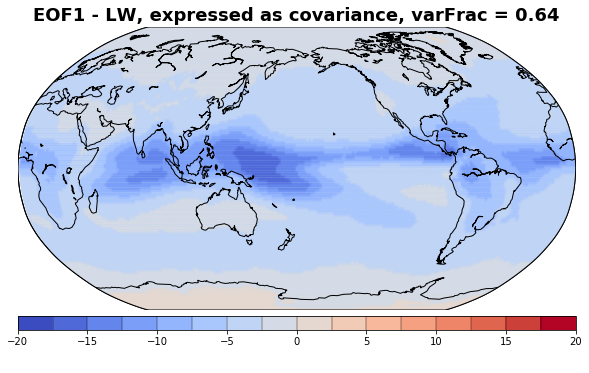

In [21]:
data = eof*(-1)
eof_nb = 1
title = "EOF1 - "+variable+", expressed as covariance, varFrac = "+str(varFrac_list[0])
label_min = -20
label_max = 20
name_figure = "PPE2_EOF1map_"+str(variable)+".png"
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

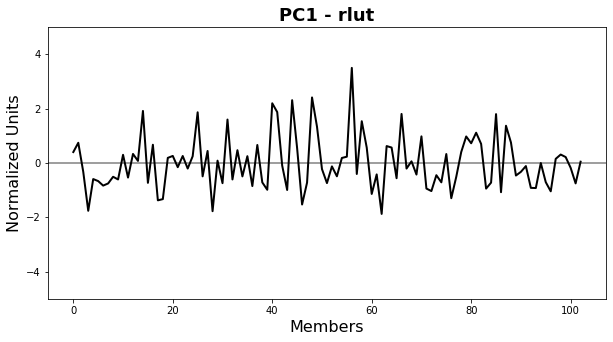

In [22]:
data = pc*(-1)
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - "+str(variables[0])
name_figure = "PPE2_EOF1pc_"+str(variable)+".png"
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 2 : plotting 

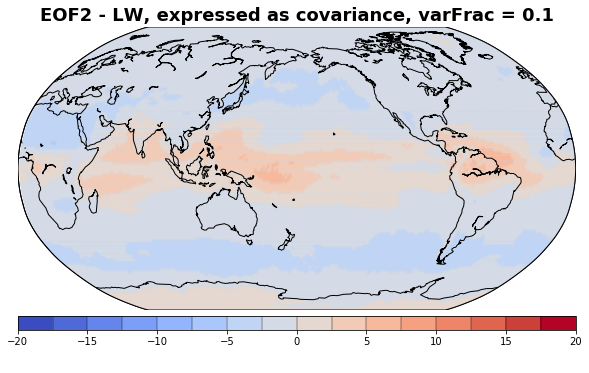

In [23]:
data = eof*(-1)
eof_nb = 2
title = "EOF2 - "+str(variable)+", expressed as covariance, varFrac = "+str(varFrac_list[1])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF2map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

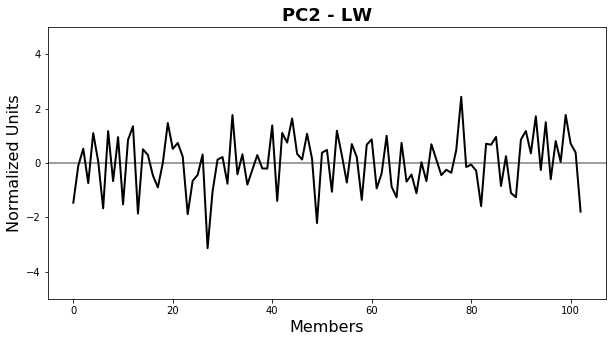

In [24]:
data = pc*(-1)
pc_nb = 2
ymin = -5
ymax = 5
title = 'PC2 - '+str(variable)
name_figure = 'PPE2_EOF2pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 3 : plotting

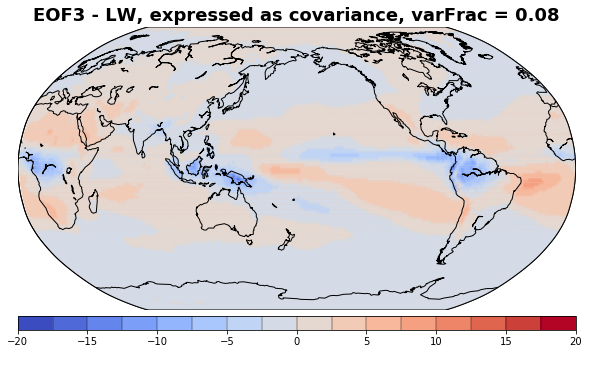

In [25]:
data = eof*(-1)
eof_nb = 3
title = 'EOF3 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[2])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF3map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

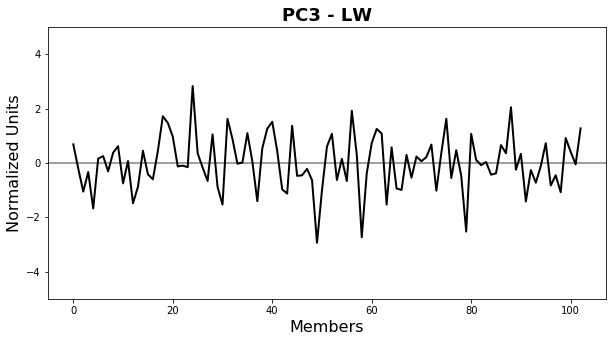

In [26]:
data = pc*(-1)
pc_nb = 3
ymin = -5
ymax = 5
title = 'PC3 - '+str(variable)
name_figure = 'PPE2_EOF3pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 4 : plotting 

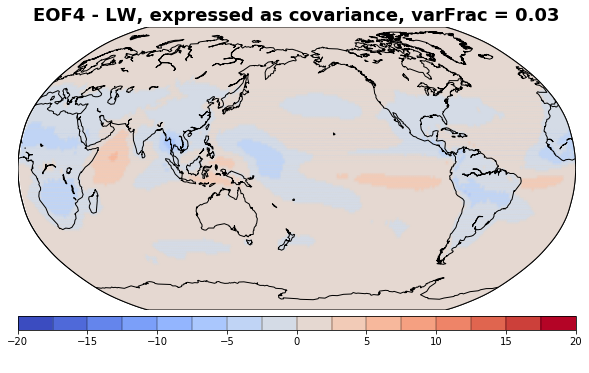

In [27]:
data = eof
eof_nb = 4
title = 'EOF4 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[3])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF4map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

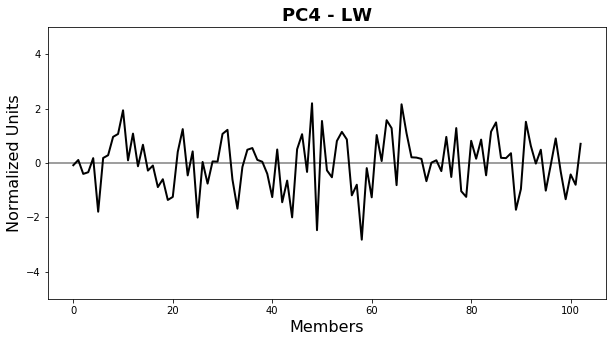

In [28]:
data = pc
pc_nb = 4
ymin = -5
ymax = 5
title = 'PC4 - '+str(variable)
name_figure = 'PPE2_EOF4pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 5 : plotting 

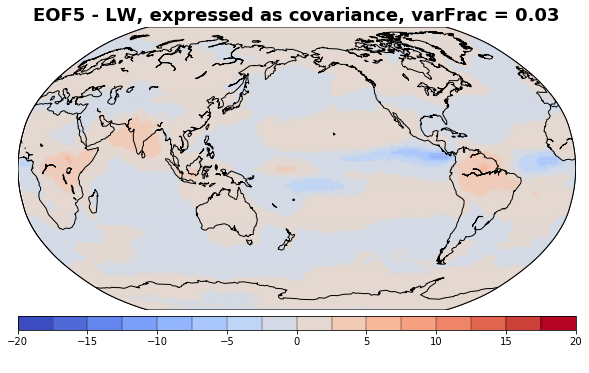

In [29]:
data = eof
eof_nb = 5
title = 'EOF5 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[4])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF5map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

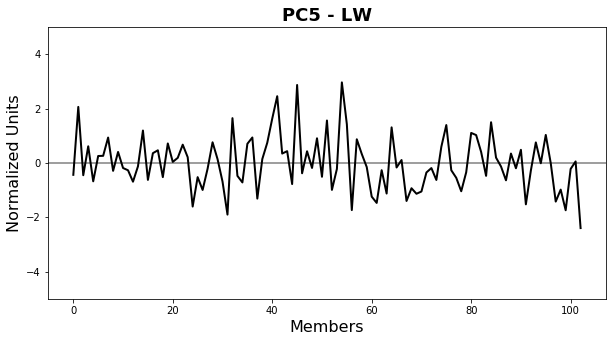

In [30]:
data = pc
pc_nb = 5
ymin = -5
ymax = 5
title = 'PC5 - '+str(variable)
name_figure = 'PPE2_EOF5pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### Save data

#### EOFs

In [35]:
for i in range(0,5,1) :
    j = i+1
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    # Save the numpy array in a file  
    EOF_df.to_pickle(path_file_npy+"/PPE2_EOFmap"+str(j)+"_"+str(variable)+".npy")

#### Principal Components

In [36]:
for i in range(0,5,1) :
    j = i+1
    pc_p1 = pc[0,i]
    PC = pc[1:,i]
    
    # Save the numpy array in a file   
    np.save(path_file_npy+'/p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_file_npy+'/PPE2_EOF'+str(j)+'pc_'+str(variable)+'.npy', PC)

#### Variance explained, Mean and Anomalies

In [37]:
## --VarFrac 
np.save(path_file_npy+'/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

## --Mean
mean_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_mean.npy')

## --Anom
anom_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_anom.npy')

### [Back to the top](#top)

# <a id="emulator">Step 2 - MultiLinReg predictions</a> </li>

Use of statistical emulators to predict, based on the perturbed parameter values, ARPEGE-Climat's outputs. The emulators must predict both the climate control mean state (here the global mean tas) and the global net feedback (in another code).  


The emulator is a simple multi linear regression model built and trained to predict the five first $PCs$ of the EOF analysis estimated in [Step 1](#EOF). It is expressed as followed : 
\begin{equation}
    Y = \Sigma_{j=1}^K a_jx_j + R 
    \label{eq_emulator}
\end{equation}

with $Y = PC_i$ the PC of one mode of the EOF analysis ($i=5$), $x_j$ the parameter values, $a_j$ the regression coefficients estimated based on the training of the model, $R$ the intercept and $K=30$ the number of perturbed parameter.

### Functions

In [38]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions_emulation
from Fonctions_emulation import Lasso_tunage
from Fonctions_emulation import Lasso_model
from Fonctions_emulation import plot_model_skill
from Fonctions_emulation import plot_model_skill_lines
from Fonctions_emulation import Lasso_pred
from Fonctions_emulation import MultiLinReg_model
from Fonctions_emulation import MultiLinReg_pred

### EOF 1 - prediction

In [39]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [40]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.003914702614780118
Coefficients: 
 [-0.09479453 -0.0912179   0.01075005  0.00345058 -0.01185018 -0.01842847
 -0.03422736  0.16905064 -0.13842308  0.62275347 -0.25578356 -0.21117264
 -0.01389694  0.16518685  0.11861888  0.13853981  0.08279218  0.03100197
 -0.07176775  0.01341767 -0.0949468  -0.11976196  0.2527526  -0.13862526
 -0.02870624 -0.14036009  0.083972   -0.04615504 -0.09816183 -0.0021733 ]
Score: 
 0.7996790278581019


,y_true,y_eq,members,members_0
0,-0.740480,-0.259882,p311,0
1,0.330506,0.318816,p312,1
2,1.761387,1.703499,p314,2
3,0.594125,0.698064,p316,3
4,0.669139,1.829156,p317,4
...,...,...,...,...
97,-0.307394,0.325354,p465,97
98,-0.214972,0.257693,p467,98
99,0.179647,-0.562739,p469,99
100,0.754413,1.072531,p470,100


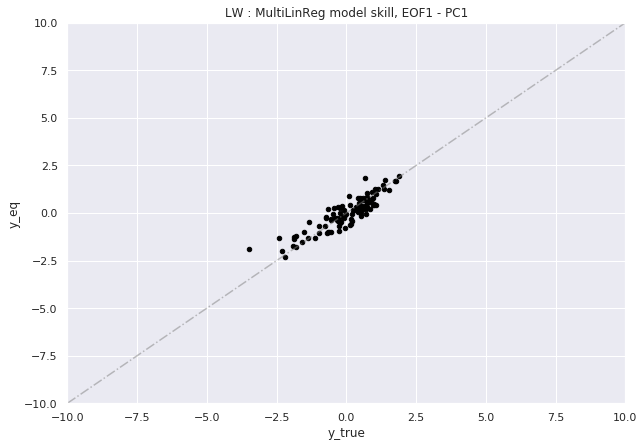

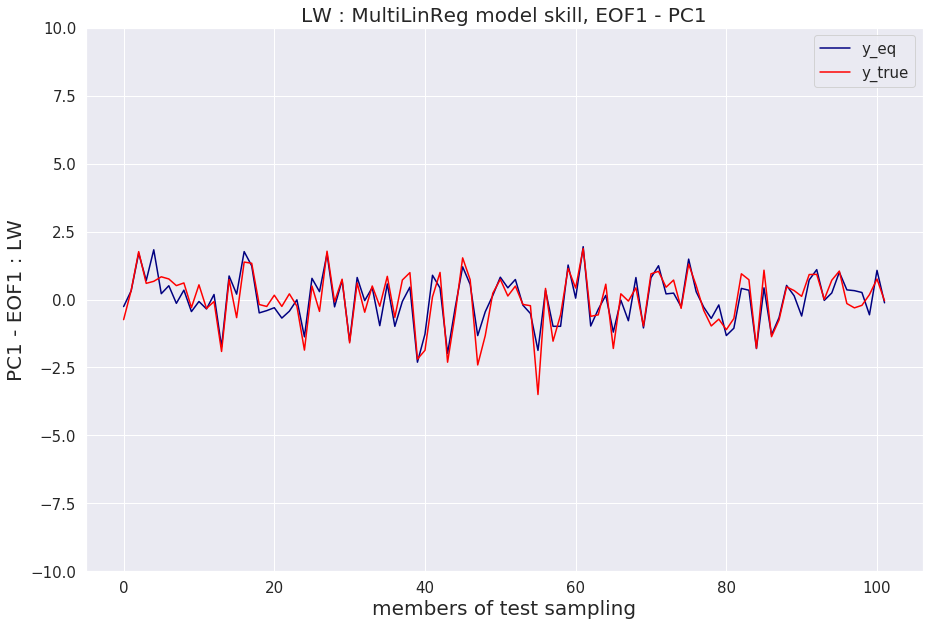

In [43]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF1 - PC1'
xmin = -10
xmax = 10
ymin = -10
ymax = 10
name = 'MultiLinReg_'+variable+'_skill_pc1.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC1 - EOF1 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [44]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.421383,102.0
1,-0.675840,103.0
2,0.195314,104.0
3,1.322120,105.0
4,-0.016469,106.0
...,...,...
99995,-1.037028,100097.0
99996,-0.778066,100098.0
99997,0.241466,100099.0
99998,-0.282413,100100.0


#### Save data

In [45]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 2 - prediction

In [46]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [47]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.014355560590477389
Coefficients: 
 [-0.16318084 -0.19341022 -0.2383127  -0.00857134  0.06088509 -0.04670961
  0.01870661 -0.18420239  0.03504069 -0.13009492 -0.27011668 -0.48030743
  0.11230984  0.20287445 -0.13476325 -0.13163762  0.00904048 -0.28152419
  0.06305552 -0.1018529  -0.01195573  0.16151768 -0.2223299  -0.22075479
 -0.06524807 -0.15446558 -0.08274223  0.06884572  0.00213489 -0.26756243]
Score: 
 0.8389828349969257


,y_true,y_eq,members,members_0
0,0.104699,0.038747,p311,0
1,-0.523540,-0.689953,p312,1
2,0.742655,1.068105,p314,2
3,-1.095556,-0.822404,p316,3
4,-0.061055,0.710213,p317,4
...,...,...,...,...
97,-0.038708,0.293633,p465,97
98,-1.763033,-1.455435,p467,98
99,-0.710408,-0.090180,p469,99
100,-0.382708,0.070195,p470,100


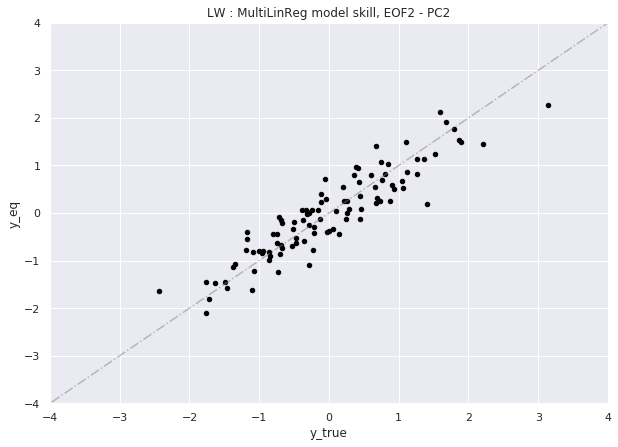

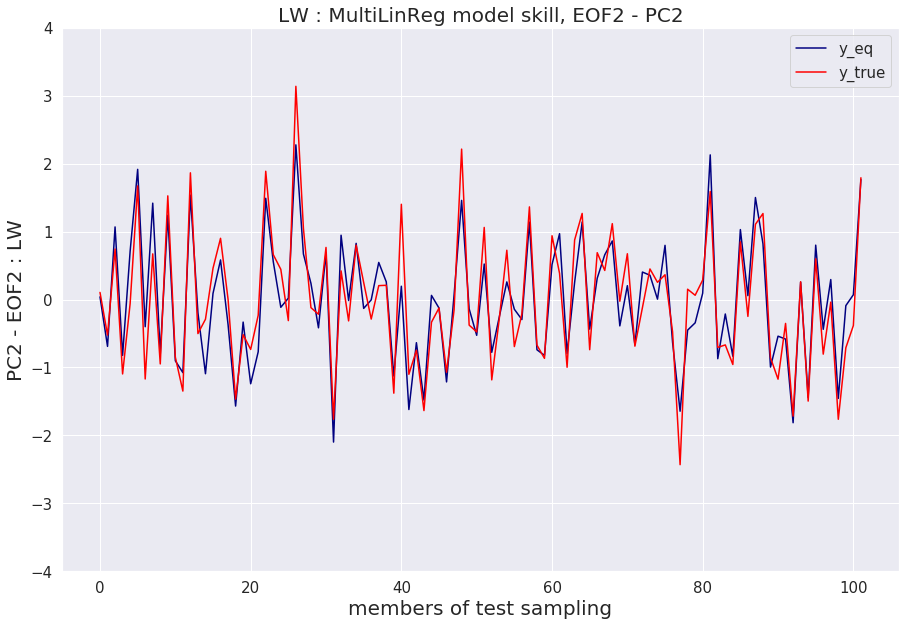

In [48]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF2 - PC2'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc2.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC2 - EOF2 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [49]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.386856,102.0
1,-0.682942,103.0
2,-0.122729,104.0
3,-0.832009,105.0
4,0.964496,106.0
...,...,...
99995,0.285278,100097.0
99996,0.811393,100098.0
99997,-0.819363,100099.0
99998,-0.476100,100100.0


#### Save data

In [50]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 3 - prediction

In [51]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [52]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.00668011917629665
Coefficients: 
 [ 0.29547139  0.47976245  0.25506821  0.02264101 -0.11507878  0.34218787
  0.07463232 -0.01227843  0.18459746  0.21846355 -0.09553144 -0.10611553
  0.20571516  0.17256982 -0.30012958 -0.00814464  0.07135526  0.09603105
 -0.03228769 -0.03254554 -0.03318823 -0.09991305  0.25017498  0.23311332
 -0.03031748 -0.04001668  0.04802984  0.03846402  0.22851275  0.06845399]
Score: 
 0.8519553985563667


,y_true,y_eq,members,members_0
0,0.212184,-0.208715,p311,0
1,1.055395,0.748774,p312,1
2,0.336021,0.551831,p314,2
3,1.673748,1.259808,p316,3
4,-0.157611,-0.534948,p317,4
...,...,...,...,...
97,1.080690,0.448048,p465,97
98,-0.917576,-0.331177,p467,98
99,-0.411871,-0.641038,p469,99
100,0.054906,-0.514364,p470,100


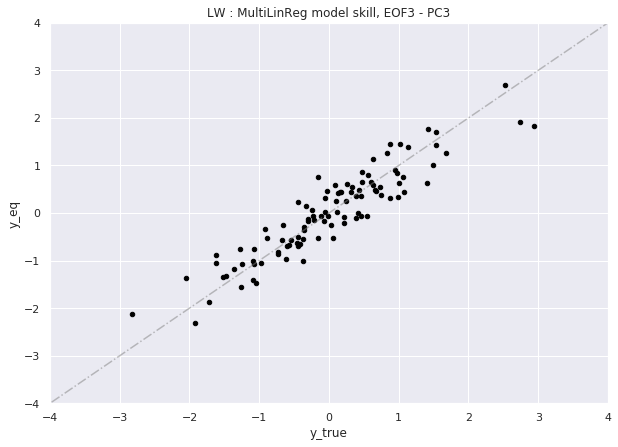

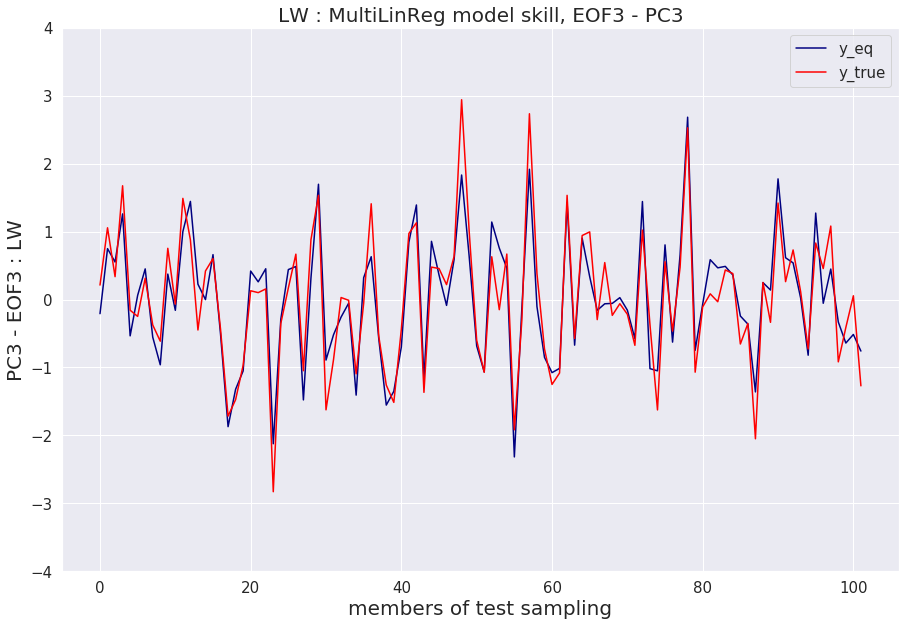

In [53]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF3 - PC3'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc3.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC3 - EOF3 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [54]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-0.962113,102.0
1,-1.264687,103.0
2,0.498872,104.0
3,0.251881,105.0
4,-0.086192,106.0
...,...,...
99995,-0.105779,100097.0
99996,0.189745,100098.0
99997,-0.452265,100099.0
99998,-1.671276,100100.0


#### Save data

In [55]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 4 - prediction

In [56]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [57]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.0008359853161646536
Coefficients: 
 [-0.1058492   0.05985845  0.26297469 -0.00078929  0.0244887   0.52206841
 -0.05456481 -0.10607684 -0.05371832 -0.25774423 -0.31706918 -0.08514907
 -0.10374362  0.06103627  0.1860933   0.00793057  0.08846996  0.10626351
  0.20655798 -0.05546097 -0.03022283 -0.14557168  0.06948936 -0.17537499
  0.02160256  0.05785721  0.01041117 -0.12262973  0.04499836  0.13950646]
Score: 
 0.6470949625736626


,y_true,y_eq,members,members_0
0,0.107153,0.554664,p311,0
1,-0.404610,-0.230138,p312,1
2,-0.343339,-0.519621,p314,2
3,0.175375,0.018599,p316,3
4,-1.795885,-0.882084,p317,4
...,...,...,...,...
97,-0.315851,0.826571,p465,97
98,-1.336611,-0.152656,p467,98
99,-0.425134,-0.404747,p469,99
100,-0.803982,-1.131696,p470,100


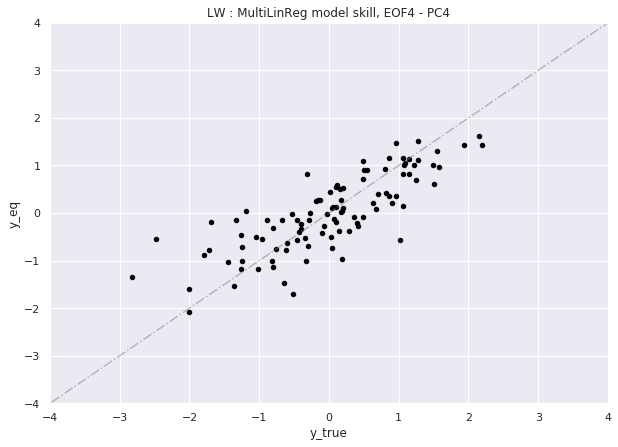

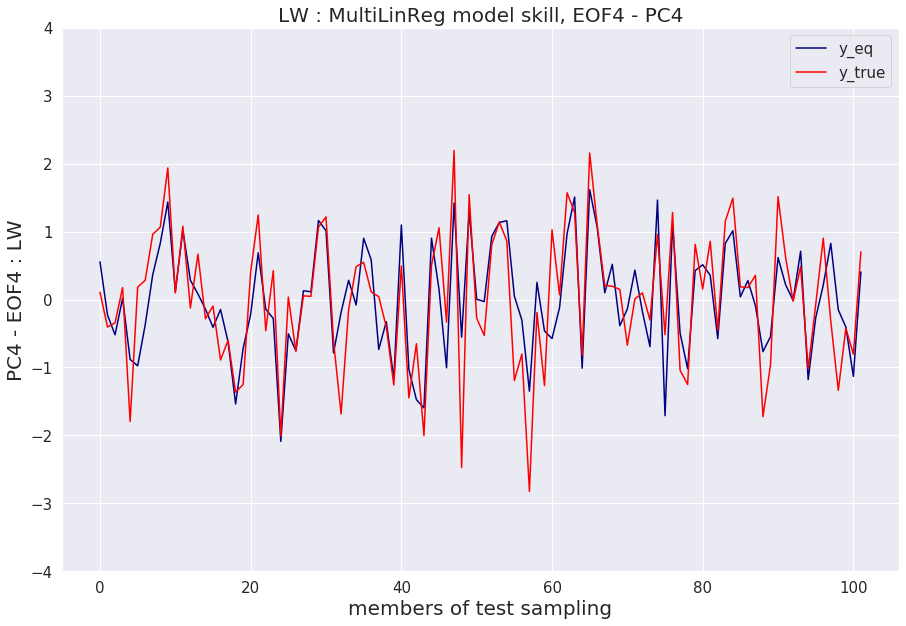

In [58]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF4 - PC4'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc4.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC4 - EOF4 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [59]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.402861,102.0
1,0.638705,103.0
2,-1.150720,104.0
3,-0.199913,105.0
4,1.384305,106.0
...,...,...
99995,0.587497,100097.0
99996,-0.890010,100098.0
99997,-0.837164,100099.0
99998,-2.193554,100100.0


#### Save data

In [60]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 5 - prediction

In [61]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [62]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.004301445325774967
Coefficients: 
 [ 0.29221841  0.15479832 -0.0642586   0.10443696 -0.01936619 -0.12003924
 -0.04750351 -0.10430611 -0.01481681 -0.18713411 -0.11193239 -0.0818865
 -0.1073501   0.04259146  0.26907848  0.12874614 -0.0316798   0.07357905
  0.07332547  0.1349796  -0.18907189 -0.1701456  -0.0566516   0.28402382
  0.03714524 -0.07442345  0.04239468  0.00380736  0.00453817  0.05071673]
Score: 
 0.5692649655968949


,y_true,y_eq,members,members_0
0,2.060030,0.831489,p311,0
1,-0.453188,-0.636982,p312,1
2,0.612261,0.986379,p314,2
3,-0.678549,-0.692560,p316,3
4,0.253998,0.782832,p317,4
...,...,...,...,...
97,-0.982651,0.920351,p465,97
98,-1.742670,-1.692200,p467,98
99,-0.221728,-0.795173,p469,99
100,0.054235,-0.390015,p470,100


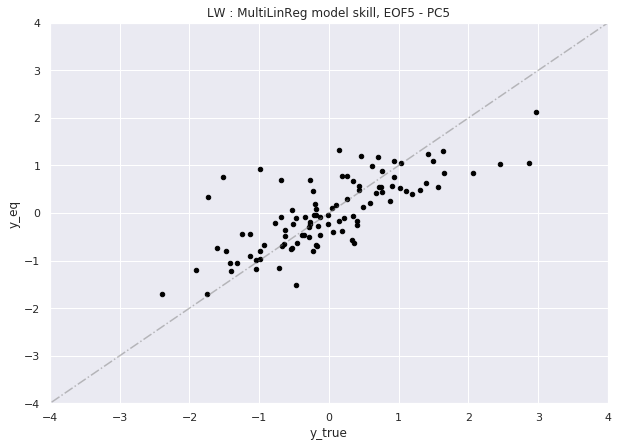

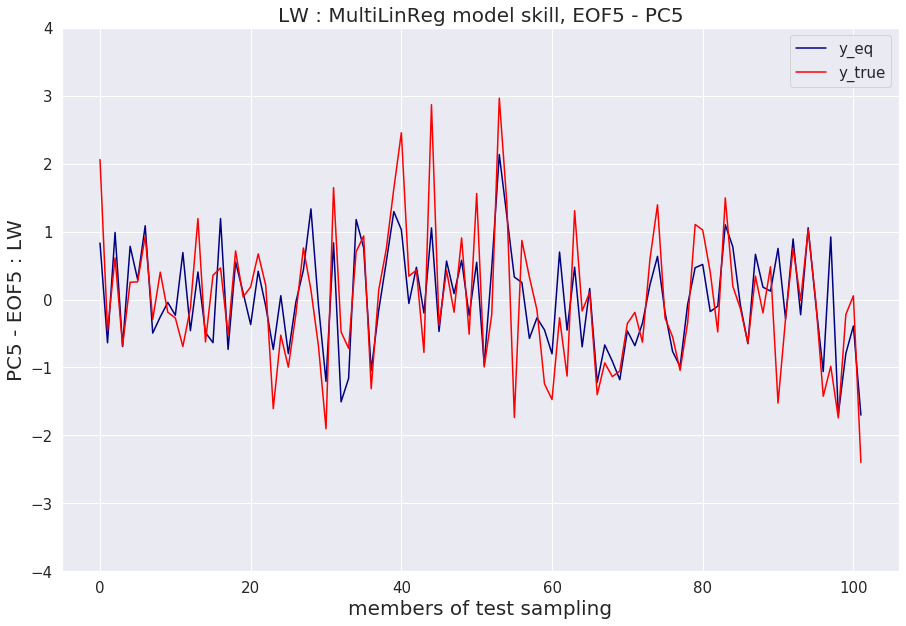

In [63]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF5 - PC5'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc5.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC5 - EOF5 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [64]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,1.142475,102.0
1,1.120958,103.0
2,-0.470387,104.0
3,1.381311,105.0
4,0.985399,106.0
...,...,...
99995,-1.237020,100097.0
99996,0.031540,100098.0
99997,-0.092146,100099.0
99998,-0.082747,100100.0


#### Save data

In [65]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy', 
        MultiLinReg_prediction)

### [Back to the top](#top)

# <a id="observation">Step 3 - Projection of observation dataset</a> </li>

In this section, we project the observations ($X_{obs}$) onto the EOFs calculated in [Step 1](#EOF). We call $U_{ens}$ the ensemble matrix of EOF amplitudes $w$ such as :  

$U_{ens} = \begin{pmatrix} 
                w_{1,1} & w_{2,1} & w_{3,1} & w_{4,1} & w_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                w_{1,102} & w_{2,102} & w_{3,102} & w_{4,102} & w_{5,102}
           \end{pmatrix}$ 
           
           
<br>
<br>
<br>
The ensemble matrix of spatial patterns is called $v_{ens}$ and is expresses such as : 

$v_{ens} = \begin{pmatrix} 
                eof1(lat,lon)  \\ 
                eof2(lat,lon)  \\ 
                eof3(lat,lon)  \\ 
                eof4(lat,lon)  \\ 
                eof5(lat,lon)  \\ 
           \end{pmatrix}$ 


<br>

The EOF analysis can be expresses as : 
$X_{ens} = U_{ens} \cdot v_{ens}$

And we want the EOF amplitudes of the observations within this basis such as : 

$X_{obs} = U_{obs} \cdot v_{ens}$ 

$U_{obs} = X_{obs} \cdot {v_{ens}}^{-1}$

With : 

$U_{obs} = \begin{pmatrix} 
                o_{1,1} & o_{2,1} & o_{3,1} & o_{4,1} & o_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                o_{1,102} & o_{2,102} & o_{3,102} & o_{4,102} & o_{5,102}
           \end{pmatrix}$ 

### Settings

In [66]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

### Functions

In [67]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

### Get the data 

In [68]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
Mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[141.47647, 141.47647, 141.47647, ..., 141.47647, 141.47647,
        141.47647],
       [144.50845, 144.50845, 144.50845, ..., 144.50845, 144.50845,
        144.50845],
       [145.13237, 145.13237, 145.13237, ..., 145.86823, 145.13237,
        145.13237],
       ...,
       [189.54474, 189.54474, 189.54474, ..., 189.62494, 189.54474,
        189.54474],
       [189.50299, 189.50299, 189.50299, ..., 189.50299, 189.50299,
        189.50299],
       [187.76024, 187.76024, 187.76024, ..., 187.76024, 187.76024,
        187.76024]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'LWmean'

In [69]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)

#PC_df

In [70]:
# Load data and compute Annual Cycle :
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [71]:
df_obs[variable] =  df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

In [72]:
X_obs = obs[variable] - Mean
X_obs_bis = (X_obs*W_eof_2D)
U_obs_avg = solver.projectField(X_obs_bis, neofs=5, weighted=False, eofscaling=1)#[0,:]
U_obs_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([-0.06824454,  1.23118156, -2.37441912,  0.02912434, -1.284239  ])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

### Save data

In [73]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy', U_obs_avg)

# Projection of CFMIP data

In [74]:
variables = ['rlut']

In [75]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [76]:
# Download the amip dataframes and compute the radiative budget  

path = "/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/"
filename = "*_amip_*.nc"
CNRM_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/MRI-ESM2-0/amip/"
filename = "*_amip_*regrid.nc"
MRI_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/CanESM5/amip/"
filename = "standard_*_amip_*regrid.nc"
CAN_amip = load_monthly_clim(path, filename, variables)
CAN_amip

path = "/data/scratch/globc/peatier/CMIP6/MIROC6/"
filename = "*_amip_*regrid.nc"
MIROC_amip = load_monthly_clim(path, filename, variables)
MIROC_amip

path = "/data/scratch/globc/peatier/CMIP6/HadGEM3-GC31-LL/"
filename = "standard_*_amip_*regrid.nc"
HadGEM3_amip = load_monthly_clim(path, filename, variables)
HadGEM3_amip

path = "/data/scratch/globc/peatier/CMIP6/IPSL-CM6A-LR/"
filename = "*_amip_*regrid.nc"
IPSL_amip = load_monthly_clim(path, filename, variables)
IPSL_amip

path = "/data/scratch/globc/peatier/CMIP6/BCC-CSM2-MR/"
filename = "standard_*_amip_*regrid.nc"
BCC_amip = load_monthly_clim(path, filename, variables)
BCC_amip

rlut  height
month lat        lon                          
1     -88.927735 0.00000    185.960541     2.0
                 1.40625    185.925110     2.0
                 2.81250    185.888687     2.0
                 4.21875    185.853851     2.0
                 5.62500    185.800659     2.0
...                                ...     ...
12     88.927735 352.96875  165.538513     2.0
                 354.37500  165.532074     2.0
                 355.78125  165.529419     2.0
                 357.18750  165.519089     2.0
                 358.59375  165.541138     2.0

[393216 rows x 2 columns]

In [78]:
#variables = ['SW']

df_obs = pd.DataFrame()
df_obs['CNRM'] = CNRM_amip[variables[0]]
df_obs['MRI'] = MRI_amip[variables[0]]
df_obs['CAN'] = CAN_amip[variables[0]]
df_obs['MIROC'] = MIROC_amip[variables[0]]
df_obs['HadGEM3'] = HadGEM3_amip[variables[0]]
df_obs['IPSL'] = IPSL_amip[variables[0]]
df_obs['BCC'] = BCC_amip[variables[0]]
#df_obs = df_obs.drop(['rsut', 'height'], axis = 1)
df_obs

CNRM         MRI         CAN       MIROC  \
month lat        lon                                                         
1     -88.927735 0.00000    185.312866  191.050308  194.395706  199.672424   
                 1.40625    185.312866  190.944885  194.394623  199.639511   
                 2.81250    185.312866  190.871658  194.044556  199.592834   
                 4.21875    185.312866  190.784973  194.043549  199.539337   
                 5.62500    185.312866  190.762955  194.042526  199.481033   
...                                ...         ...         ...         ...   
12     88.927735 352.96875  172.606918  169.241440  165.647949  163.121719   
                 354.37500  172.606918  169.257797  165.759399  163.137863   
                 355.78125  172.606918  169.250305  165.759644  163.157043   
                 357.18750  172.606918  169.255676  165.863510  163.157791   
                 358.59375  172.606918  169.260330  165.863800  163.163940   

                               HadGEM3        IPSL         BCC  
month lat        lon                                            
1     -88.927735 0.00000    192.111023  189.196426  185.960541  
                 1.40625    192.087799  189.144714  185.925110  
                 2.81250    192.078903  189.089417  185.888687  
                 4.21875    192.046692  189.021576  185.853851  
                 5.62500    192.015869  188.955856  185.800659  
...                                ...         ...         ...  
12     88.927735 352.96875  168.190277  177.472336  165.538513  
                 354.37500  168.202057  177.507263  165.532074  
                 355.78125  168.214233  177.521210  165.529419  
                 357.18750  168.229095  177.518356  165.519089  
                 358.59375  168.240646  177.534149  165.541138  

[393216 rows x 7 columns]

In [79]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    CNRM     (lat, lon) float32 141.31741 141.31741 ... 190.55353 190.55353
    MRI      (lat, lon) float32 144.62071 144.55673 ... 191.9757 191.97809
    CAN      (lat, lon) float32 145.37804 145.37663 ... 190.26115 190.2614
    MIROC    (lat, lon) float32 145.74411 145.68283 ... 186.1432 186.14372
    HadGEM3  (lat, lon) float32 142.43832 142.40167 ... 191.7751 191.78168
    IPSL     (lat, lon) float32 143.39436 143.30669 ... 196.88176 196.88039
    BCC      (lat, lon) float32 141.79498 141.73112 ... 190.28763 190.28816

## Compute Anomaly

In [80]:
X_obs = {}
X_obs['CNRM'] = obs['CNRM'] - Mean
X_obs['MRI'] = obs['MRI'] - Mean
X_obs['CAN'] = obs['CAN'] - Mean
X_obs['MIROC'] = obs['MIROC'] - Mean
X_obs['HadGEM3'] = obs['HadGEM3'] - Mean
X_obs['IPSL'] = obs['IPSL'] - Mean
X_obs['BCC'] = obs['BCC'] - Mean
#X_obs

In [81]:
X_obs['CNRM'] = (X_obs['CNRM']*W_eof_2D)
U_CNRM_avg = solver.projectField(X_obs['CNRM'], neofs=5, weighted=False, eofscaling=1)

X_obs['MRI'] = (X_obs['MRI']*W_eof_2D)
U_MRI_avg = solver.projectField(X_obs['MRI'], neofs=5, weighted=False, eofscaling=1)

X_obs['CAN'] = (X_obs['CAN']*W_eof_2D)
U_CAN_avg = solver.projectField(X_obs['CAN'], neofs=5, weighted=False, eofscaling=1)

X_obs['MIROC'] = (X_obs['MIROC']*W_eof_2D)
U_MIROC_avg = solver.projectField(X_obs['MIROC'], neofs=5, weighted=False, eofscaling=1)

X_obs['HadGEM3'] = (X_obs['HadGEM3']*W_eof_2D)
U_HadGEM3_avg = solver.projectField(X_obs['HadGEM3'], neofs=5, weighted=False, eofscaling=1)

X_obs['IPSL'] = (X_obs['IPSL']*W_eof_2D)
U_IPSL_avg = solver.projectField(X_obs['IPSL'], neofs=5, weighted=False, eofscaling=1)

X_obs['BCC'] = (X_obs['BCC']*W_eof_2D)
U_BCC_avg = solver.projectField(X_obs['BCC'], neofs=5, weighted=False, eofscaling=1)

In [83]:
#Save the U_obs_avg 
np.save(path_file_npy+'/U_CNRM_'+variable+'.npy', U_CNRM_avg)
np.save(path_file_npy+'/U_MRI_'+variable+'.npy', U_MRI_avg)
np.save(path_file_npy+'/U_CAN_'+variable+'.npy', U_CAN_avg)
np.save(path_file_npy+'/U_MIROC_'+variable+'.npy', U_MIROC_avg)
np.save(path_file_npy+'/U_HadGEM3_'+variable+'.npy', U_HadGEM3_avg)
np.save(path_file_npy+'/U_IPSL_'+variable+'.npy', U_IPSL_avg)
np.save(path_file_npy+'/U_BCC_'+variable+'.npy', U_BCC_avg)

### [Back to the top](#top)

# <a id="RMSE">Step 4 - RMSE estimate</a> </li>

The model error as compared to observations is calculated by comparing the EOF amplitudes $w$ in each member with the projection of the observations $o$ on the model EOF basis through a Root Mean Square Error (RMSE). For a given member of the PPE, the error associated with the variable $s$ is : 

\begin{equation}
    E_{s} = \sqrt{\Sigma_i^N \frac{(w_{is}-o_{is})^2}{N}}
\end{equation}

with $i$ varying from $1$ to $N$, the number of modes considered. In the present study, we truncated the EOF after the 5th mode for each variable : $N=5$.

### Settings

In [84]:
product = 'CERES'
N_error = 128*256

### Functions

In [85]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [86]:
def RMSE(mod, obs) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

In [87]:
def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs)
    return diff

### Get the data 

In [88]:
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

In [89]:
eofs=[]
for i in range(1,6,1) :
    eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(eof_tmp)
                     
## --Combine the 5 modes for reconstruction
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [90]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

### p1 default model

In [91]:
pc_p1=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/p1_EOF'+str(i)+'pc_'+variable+'.npy')
    pc_p1.append(pc_tmp)

p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [92]:
pc = pc_p1
nb_dims = 2
X_rec_p1 = reconstruct_X(eofs_combined, pc, nb_dims)
X_rec_p1

<xarray.DataArray (lat: 128, lon: 256)>
array([[-0.30336733, -0.30336733, -0.30336733, ..., -0.30336733,
        -0.30336733, -0.30336733],
       [-0.55237914, -0.55237914, -0.55237914, ..., -0.55237914,
        -0.55237914, -0.55237914],
       [-0.8085224 , -0.8085224 , -0.8085224 , ..., -0.78905868,
        -0.8085224 , -0.8085224 ],
       ...,
       [ 0.30278565,  0.30278565,  0.30278565, ...,  0.3032706 ,
         0.30278565,  0.30278565],
       [ 0.22206829,  0.22206829,  0.22206829, ...,  0.22206829,
         0.22206829,  0.22206829],
       [ 0.13599674,  0.13599674,  0.13599674, ...,  0.13599674,
         0.13599674,  0.13599674]])
Coordinates:
    mode     <U4 'eofs'
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [93]:
E_p1 = RMSE_rec(X_rec_p1, X_rec_obs, Mean)
E_p1

<xarray.DataArray ()>
array(4.32785714)

In [98]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'
variable_obs = 'LW'

path = path_observation
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs[variable_obs] =  df_obs['toa_lw_all_mon']

obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

In [99]:
mod = amip_list[0]
observation = obs[variable]
RMSE_p1 = RMSE(mod, observation).values
RMSE_p1

array(7.73483901)

### CMIP6 models

In [100]:
nb_dims = 2

## Reconstruct and compute RMSE_rec 

filename = 'U_MRI_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_MRI = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_CAN_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_CAN = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_MIROC_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_MIROC = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_HadGEM3_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_HadGEM3 = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_IPSL_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_IPSL = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_BCC_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_BCC = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

### PPE

In [101]:
pc_PPE=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/PPE2_EOF'+str(i)+'pc_'+str(variable)+'.npy')
    pc_PPE.append(pc_tmp)

In [102]:
X_PPE = []
for i in range(0,102,1) :
    pc = [pc_PPE[0][i], pc_PPE[1][i], pc_PPE[2][i], pc_PPE[3][i], pc_PPE[4][i]]
    nb_dims = 2
    X_PPE_tmp = reconstruct_X(eofs_combined, pc, nb_dims)
    
    X_PPE.append(X_PPE_tmp)

In [103]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

In [104]:
E_PPE = []
RMSE_PPE = []
observation = obs[variable]
mod_list = amip_list[1:]  ## --Because amip_list[0] is p1

for i in range(0,len(X_PPE),1) :
    E_PPE_tmp = RMSE_rec(X_PPE[i], X_rec_obs, Mean)
    RMSE_PPE_tmp = RMSE(mod_list[i], observation)
    
    E_PPE.append(float(E_PPE_tmp))
    RMSE_PPE.append(float(RMSE_PPE_tmp))

## Check the correlation with simple RMSE

In [105]:
df_fig = pd.DataFrame(E_PPE, columns=['E_PPE'])
df_fig['RMSE_PPE'] = RMSE_PPE
df_fig

,E_PPE,RMSE_PPE
0,8.517303,11.011993
1,8.872889,11.098830
2,12.656512,14.011544
3,11.049263,12.622750
4,7.824954,10.275935
...,...,...
97,8.173671,10.659436
98,7.961097,10.806403
99,6.553689,9.883316
100,8.360200,10.799465


In [106]:
r = np.corrcoef(df_fig['E_PPE'], df_fig['RMSE_PPE'])
r = r[0,1].round(2)
r

0.98

In [107]:
E = df_fig['E_PPE']
R = df_fig['RMSE_PPE']
coeff1 = (E[90] - E[85])/(R[90] - R[85])
coeff2 = (E[50] - E[45])/(R[50] - R[45])
coeff3 = (E[100] - E[95])/(R[100] - R[95])
coeff4 = (E[80] - E[75])/(R[80] - R[75])
coeff5 = (E[60] - E[55])/(R[60] - R[55])
coeff6 = (E[101] - E[96])/(R[101] - R[96])
coeff = (coeff1 + coeff2 + coeff3 + coeff4 + coeff5)/5
line_tmp = R*coeff
intercept = E.mean() - line_tmp.mean()
line = np.arange(0.2,2.6,0.02)*coeff 
line = line + intercept

In [108]:
df_line = pd.DataFrame(line, columns=['line'])
df_line['x'] = np.arange(0.2,2.6,0.02)
df_line

,line,x
0,-8.234306,0.20
1,-8.203182,0.22
2,-8.172058,0.24
3,-8.140934,0.26
4,-8.109810,0.28
...,...,...
115,-4.655050,2.50
116,-4.623926,2.52
117,-4.592802,2.54
118,-4.561678,2.56


/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x2afcaff54c90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


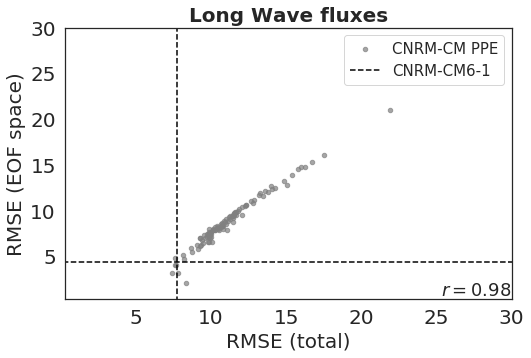

In [110]:
plt.figure(figsize=(8, 5))
    
ax = plt.gca()

df_fig.plot(kind='scatter', y='E_PPE', x='RMSE_PPE', color = 'gray', alpha=0.7, ax=ax)
df_line.plot(kind='line', y='line', x='x', color = 'gray', alpha=0.3, linestyle="-.", 
             label = '_nolegend_', ax=ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 30,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(RMSE_p1,ymin = 0,ymax = 30,label='default simulation', colors='black', 
           linestyles='dashed')

ax.set_xlabel('RMSE (total)', size = 20)
ax.set_ylabel('RMSE (EOF space)', size = 20)
ax.set_title('Long Wave fluxes', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.0,r'$r = $'+str(r),horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

plt.xlim([0.3, 30])
plt.ylim([0.3, 30])

# Legend .................

legend = ['CNRM-CM PPE', 'CNRM-CM6-1']
ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
sns.set_style(style='white') 
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Multi-Linear Regression predictions

In [111]:
pc_pred=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/MultiLinReg_prediction_eof'+str(i)+'_'+variable+'.npy')
    pc_pred.append(pc_tmp)

In [112]:
pc_val=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/MultiLinReg_validation_eof'+str(i)+'_'+variable+'.npy')
    pc_val.append(pc_tmp)

In [113]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

In [114]:
E_pred = []
nb_dims = 2

## --E_tas of MultiLinReg predictions :
for i in range(0,len(pc_pred[0]),1) : ## --100 000 for a 100 000 LHS predictions 
    
    pc = [pc_pred[0][i], pc_pred[1][i], pc_pred[2][i], pc_pred[3][i], pc_pred[4][i]]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    E_tmp = RMSE_rec(X_rec_mod, X_rec_obs, Mean)
    E_pred.append(float(E_tmp))

In [115]:
E_val = []
nb_dims = 2

## --E_tas of MultiLinReg predictions :
for i in range(0,len(pc_val[0]),1) : ## --100 000 for a 100 000 LHS predictions 
    
    pc = [pc_val[0][i], pc_val[1][i], pc_val[2][i], pc_val[3][i], pc_val[4][i]]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    E_tmp = RMSE_rec(X_rec_mod, X_rec_obs, Mean)
    E_val.append(float(E_tmp))

### Get the feedbacks

In [116]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
Fdbck_multilinreg_val = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_FdbckN.npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")

Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [117]:
E_PPE_df = pd.DataFrame(E_PPE, columns=['E_PPE'])
E_PPE_df['Fdbck'] = Fdbck_PPE

In [118]:
E_multilinreg_val_df = pd.DataFrame(E_val, columns=['E_multilinreg_val'])
E_multilinreg_val_df['Fdbck_val'] = Fdbck_multilinreg_val

E_multilinreg_pred_df = pd.DataFrame(E_pred[0:100000], columns=['E_multilinreg_pred'])
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred
#E_multilinreg_pred_df

### Plotting

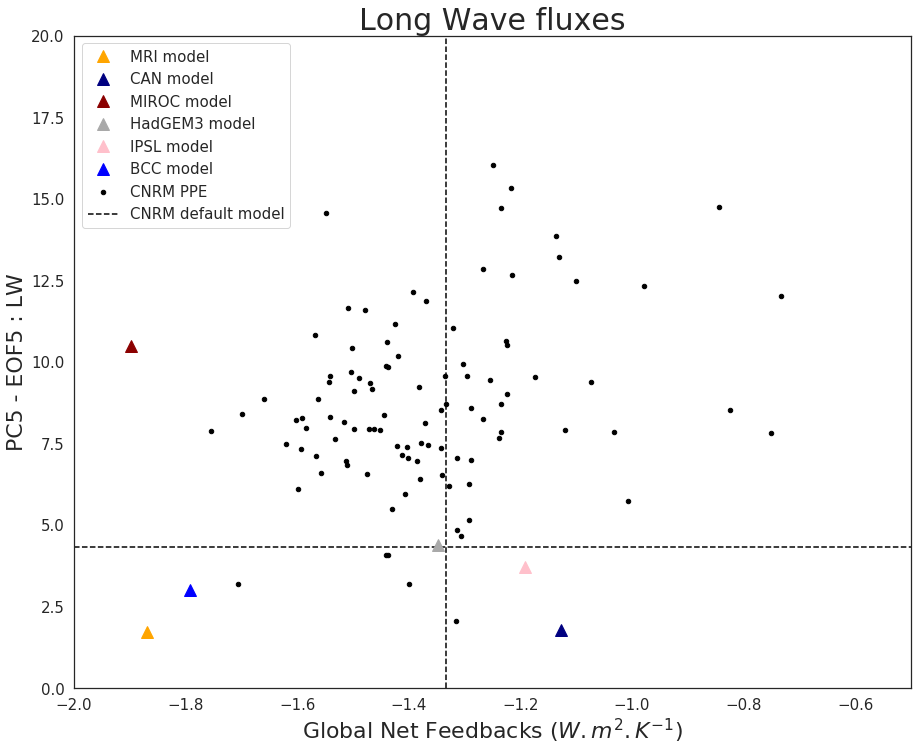

In [119]:
ax = plt.gca()

E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,20)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

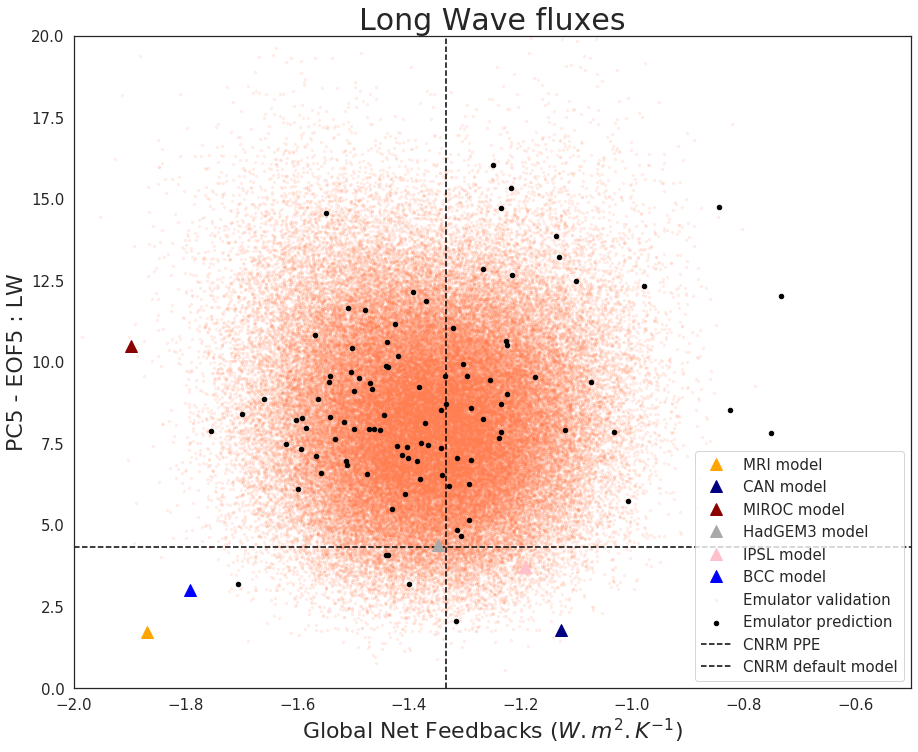

In [120]:
ax = plt.gca()

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#E_multilinreg_val_df.plot(kind='scatter', x='Fdbck_val', y='E_multilinreg_val', color='red', alpha=1, figsize=(15, 12), 
#                     marker='x', ax = ax)
E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='coral', alpha=0.1, figsize=(15, 12), marker='.', ax = ax)


E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'Emulator validation', 'Emulator prediction', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,20)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [121]:
fluxes_biases = E_PPE_df
fluxes_biases['E_multilinreg_val'] = E_multilinreg_val_df['E_multilinreg_val']
fluxes_biases['OSE_multilinreg'] = abs(fluxes_biases['E_PPE'] - fluxes_biases['E_multilinreg_val'])
fluxes_biases

,E_PPE,Fdbck,E_multilinreg_val,OSE_multilinreg
0,8.517303,-0.825236,6.229004,2.288299
1,8.872889,-1.659636,8.468629,0.404260
2,12.656512,-1.215000,12.656336,0.000176
3,11.049263,-1.321641,10.291995,0.757268
4,7.824954,-0.750397,12.378273,4.553319
...,...,...,...,...
97,8.173671,-1.516367,7.521032,0.652639
98,7.961097,-1.584491,7.935930,0.025167
99,6.553689,-1.474525,5.738241,0.815448
100,8.360200,-1.445422,8.562355,0.202155


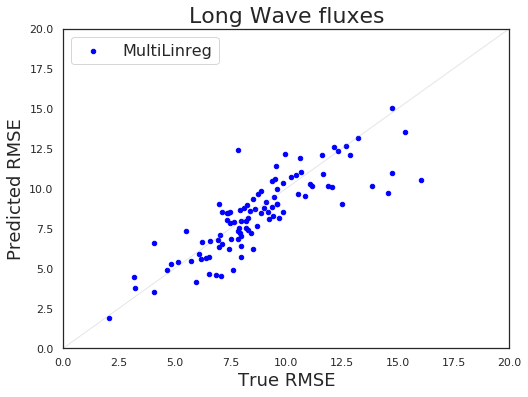

In [122]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title= TITLE 
fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_lasso_val', color='blue', alpha=0.6, 
#                     marker="o", ax = ax)

plt.xlabel('True RMSE', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted RMSE', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinreg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,20)
plt.xlim(0,20)
ax.plot((0,20), (0, 20), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### Save data 

In [123]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy', E_p1)

In [124]:
RMSE_val = fluxes_biases['E_multilinreg_val']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_val_'+variable+'.npy', RMSE_val)

In [125]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
OSE

1.1592255501449227

In [126]:
## SAVE 
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)

E_multilinreg_pred = E_multilinreg_pred_df['E_multilinreg_pred'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy', E_multilinreg_pred)

E_PPE = E_PPE_df['E_PPE'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy', E_PPE)

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [127]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedback = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [128]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
#MLR_df

In [129]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.410328,3.315892
1,-1.296605,3.544874
2,-1.516957,3.401105
3,-1.408538,3.454106
4,-1.289760,3.495946
...,...,...
4798,-1.377415,3.816600
4799,-1.312518,3.768270
4800,-1.304013,2.750311
4801,-1.357204,3.125677


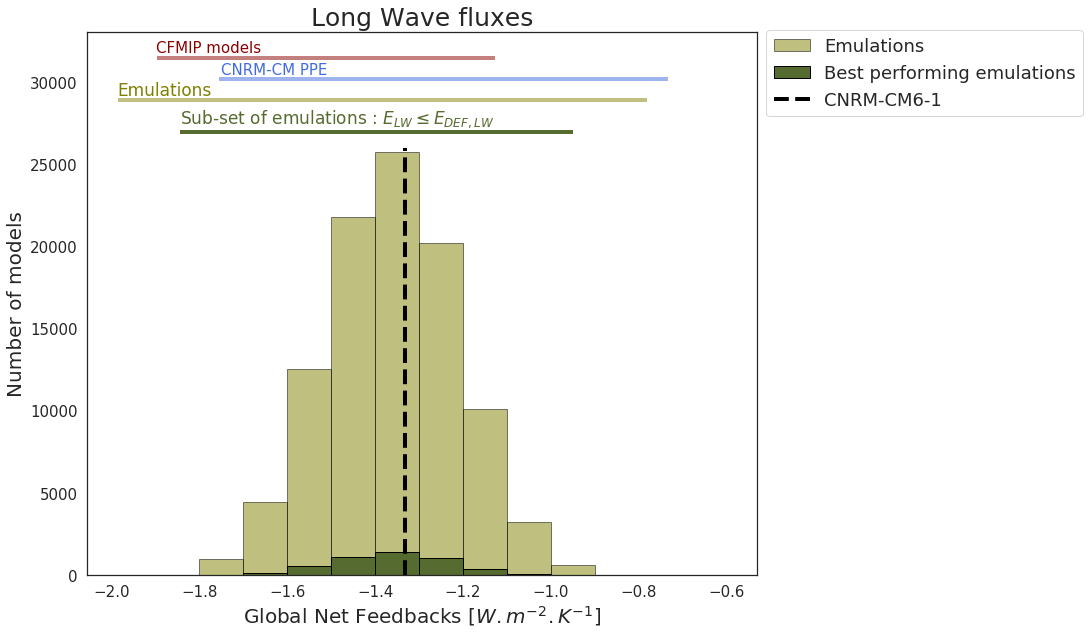

In [130]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{LW}\leq E_{DEF,LW}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [131]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [132]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

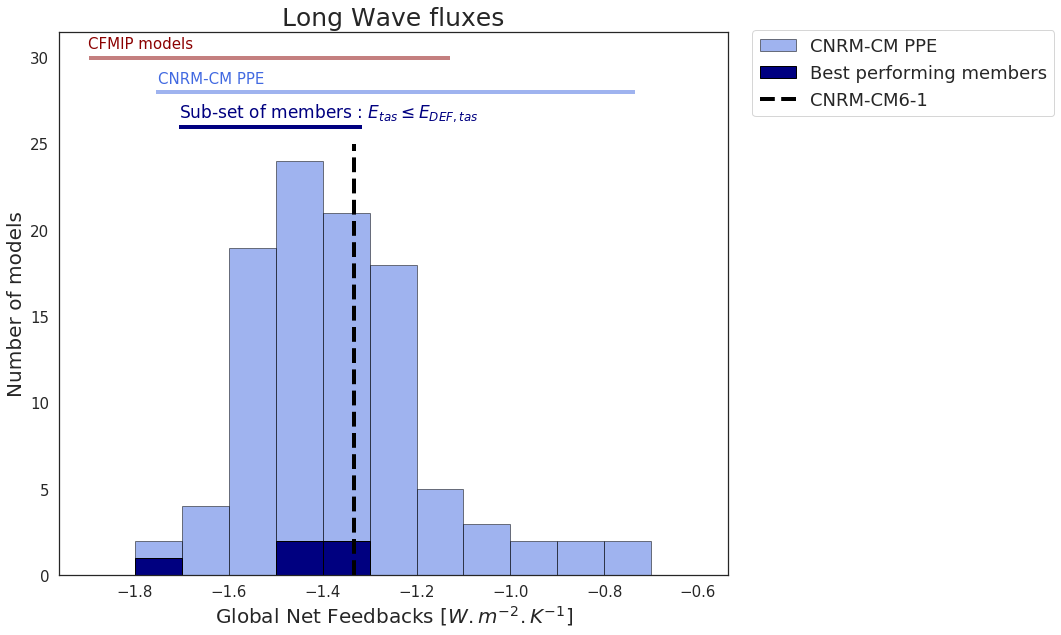

In [133]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{tas}\leq E_{DEF,tas}$', 
         color = 'navy', fontsize=17)

legend=['CNRM-CM PPE', 'Best performing members', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="optim">Step 5 - Optimisation</a> </li>

The objective here is to optimize the emulators described above in order to obtain a sub-set of the best parametrizations for each bins of feedback values. In other words, we aim to fine the parametrization which minimizes the error $E_{tot}$ given by the control mean state emulator, while showing a global net feedback value predicted by the feedback emulator within a chosen bin. It is a case of linear minimization with constraint and the optimizer used here comes from the SciPy Python's library and uses sequential least squares programming (SLSQP).

### Functions 

In [134]:
N_error = 128*256

In [135]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_eof_2D, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs, W_rmse_2D)
    return diff

In [136]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_file_npy+"/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [149]:
## --Full function predict PC from x + reconstruct 3D field + compute partial RMSE

def function_RMSE_emulator_std(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 

    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims=2)
    
    U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    pc = U_obs
    nb_dims = 2 
    X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    
    return E

def function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable, eofs_combined, 
                                   X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    return float(E)

## --Function feedbacks

def em_fdb_std(x) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file = path_file_npy+"/Net_feedbacks.npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [150]:
# -- FONCTION JACOBIAN 

def jacobian(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D) :
    
    ## -- Data
    
    Beta1 = np.load(path_file_npy+'/Beta1.npy')
    Beta2 = np.load(path_file_npy+'/Beta2.npy')
    Beta3 = np.load(path_file_npy+'/Beta3.npy')
    Beta4 = np.load(path_file_npy+'/Beta4.npy')
    Beta5 = np.load(path_file_npy+'/Beta5.npy')
    
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    nb_dims = 2 
    
    ## -- A = RMSE_rec
    A = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    #print(A)
    ## -- B = Sigma(2*(X_mod - X_rec_obs))
    toto = x - MEAN
    x_std = toto/STD
    
    pc1 = MultiLinReg_pred(x_std, 1, variable)
    pc2 = MultiLinReg_pred(x_std, 2, variable)
    pc3 = MultiLinReg_pred(x_std, 3, variable)
    pc4 = MultiLinReg_pred(x_std, 4, variable)
    pc5 = MultiLinReg_pred(x_std, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    
    add =  X_mod - X_rec_obs
    tmp = 2*eofs_combined*add
    B = tmp.sum(['lat', 'lon'])
    
    ## C = Beta*eofs_combined
    pc_beta = []
    for i in range(0, len(Beta1), 1) :
        tmp = ([Beta1[i], Beta2[i], Beta3[i], Beta4[i], Beta5[i]])
        pc_beta.append(tmp)
    C = xr.DataArray(pc_beta, dims = ['param', 'eofs'])
    
    ## -- jac = 1/(2*A) * B * C
    tmp1 = 1/(2*float(A)) 
    tmp2 = np.dot(C, B)
    jac = np.dot(tmp1, tmp2)
    
    return jac

In [138]:
## --Functions constraints on the feedbacks

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


## --Functions optimization

def Optimization(x_best, ind, xlim, variable, eofs_combined, X_rec_obs, 
                 Mean, W_eof_2D, W_rmse_2D) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable, eofs_combined, X_rec_obs, 
                                        Mean, W_eof_2D, W_rmse_2D)
        print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, 
                       args=(variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D), 
                       method='SLSQP', jac = jacobian,
                       bounds=xlim, constraints=(cons1, cons2),
                       options={'disp': True, 'ftol' : 0.001, 'maxiter' : 100})    
                        # , 'maxiter' : 250   jac = jacobian, , tol = 0.001
                        # constraints=(cons1, cons2),
    

        tmp_fun = function_RMSE_emulator(sol.x, variable, eofs_combined, X_rec_obs, 
                                         Mean, W_eof_2D, W_rmse_2D)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [139]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

### Get the data

In [140]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
E_p1

array(4.32785714)

In [141]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

,Fdbck,RMSE
0,-0.825236,8.517303
1,-1.659636,8.872889
2,-1.215000,12.656512
3,-1.321641,11.049263
4,-0.750397,7.824954
...,...,...
97,-1.516367,8.173671
98,-1.584491,7.961097
99,-1.474525,6.553689
100,-1.445422,8.360200


In [142]:
E_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_"+variable+".npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

,E_multilinreg_pred,Fdbck_pred
0,5.624554,-1.499698
1,7.002656,-1.339351
2,7.386396,-1.323732
3,11.645459,-1.541909
4,6.059144,-1.346961
...,...,...
99995,7.915299,-1.453679
99996,7.335934,-1.410350
99997,6.876754,-1.296397
99998,5.588856,-1.299809


### Initial guess for Optimization 1

In [143]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
#E_multilinreg_pred_df        

In [144]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df

In [145]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
#new_df

### Optimization 1 

In [146]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [147]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [151]:
sol_df = Optimization(x_best, 0.0001, xlim, variable, eofs_combined, X_rec_obs, 
                      Mean, W_eof_2D, W_rmse_2D)
#sol_df

fun_x0 = 10.756100738395393
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.756100738395393
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 14.434665941747587
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 14.434665941747587
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 16.236444096031054
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.236444096031054
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 18.19753209111609
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.203910705432765
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
fun_x0 = 6.989508910864229
Optimization terminated succe

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8034349960283653
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 1.9193554952124139
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8614953025582721
            Iterations: 6
            Function evaluations: 67
            Gradient evaluations: 6
fun_x0 = 1.7862723771299096
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7405985642554371
            Iterations: 17
            Function evaluations: 133
            Gradient evaluations: 13
fun_x0 = 1.7577845110793486
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7345736117201167
            Iterations: 3
            Function evaluations: 34
            Gradient evaluations: 3
fun_x0 = 1.7862542024765335
Optimization terminated successfully.    (Exit mod

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.9949484769343775
            Iterations: 7
            Function evaluations: 56
            Gradient evaluations: 5
fun_x0 = 0.5483544997741996
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4577402947590572
            Iterations: 18
            Function evaluations: 144
            Gradient evaluations: 14
fun_x0 = 1.4886922176411708
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5161235617535824
            Iterations: 6
            Function evaluations: 45
            Gradient evaluations: 4
fun_x0 = 1.7978540690779752
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7978540690779752
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 1.916871624990564
Optimization terminated successfully.    (Exit mode

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.53922032875121
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 5.528565788041156
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.466374483002877
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 6
fun_x0 = 7.511073650602028
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.511073650602028
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 7.566617700876518
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.566617700876518
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 9.035420757302441
Optimization terminated successfully.    (Exit mode 0)
        

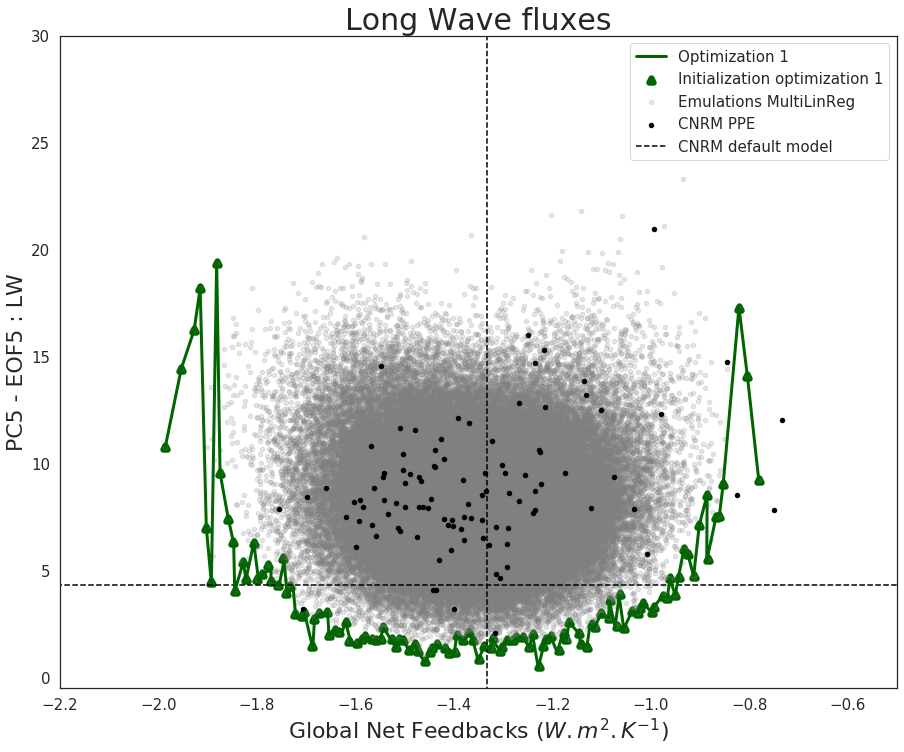

In [154]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 30,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,30)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Initial guess for Optimization 2 (param. smoothing)

In [161]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985956,0.101203,0.935243,2.308255,29.837952,-0.079684,8.934402,3.064550,0.005121,0.000707,...,-2.509369,-25.309508,0.074965,14.089321,0.000044,0.911282,0.653074,0.507018,0.534708,6.132903
1,-1.953341,0.105514,0.661300,2.259534,23.670301,-0.081930,8.177449,4.067947,0.006647,0.000753,...,-2.532433,-25.927080,0.076225,13.967110,0.000045,0.904922,0.661624,0.523649,0.543393,5.902649
2,-1.927200,0.087773,0.675335,1.873357,22.887991,-0.170906,8.389381,2.467595,0.006147,0.000652,...,-2.555063,-26.529414,0.077457,13.844024,0.000046,0.898684,0.670033,0.540065,0.551983,5.676554
3,-1.914980,0.114417,0.806305,1.895308,23.228515,-0.283923,8.542647,2.530784,0.005283,0.000544,...,-2.576850,-27.102045,0.078633,13.719231,0.000047,0.892682,0.678170,0.556058,0.560383,5.458595
4,-1.902441,0.142125,0.816974,1.742300,19.907228,-0.258710,8.397154,5.626004,0.004401,0.000695,...,-2.597429,-27.631991,0.079728,13.591976,0.000048,0.887014,0.685909,0.571438,0.568504,5.252409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.860371,0.240533,2.632661,1.592694,9.961458,-0.350414,2.619547,6.288265,0.007343,0.000328,...,-2.595956,-45.349330,0.018997,7.195788,0.000048,0.575900,0.596417,0.907432,0.890456,6.700135
109,-0.852741,0.236487,2.788497,1.182416,13.125803,-0.273103,1.681630,6.348374,0.006764,0.000514,...,-2.577381,-45.844097,0.018788,7.734029,0.000047,0.564047,0.585026,0.924666,0.899232,6.969994
110,-0.820649,0.243599,2.709574,1.004529,17.824978,-0.307878,0.703570,5.202212,0.004862,0.000647,...,-2.557619,-46.353845,0.018556,8.291967,0.000045,0.551659,0.573195,0.942453,0.908230,7.245844
111,-0.803475,0.260146,2.610912,1.301804,22.392952,-0.314653,0.679701,4.687699,0.005756,0.000710,...,-2.537022,-46.874220,0.018309,8.863455,0.000044,0.538899,0.561060,0.960618,0.917379,7.525742


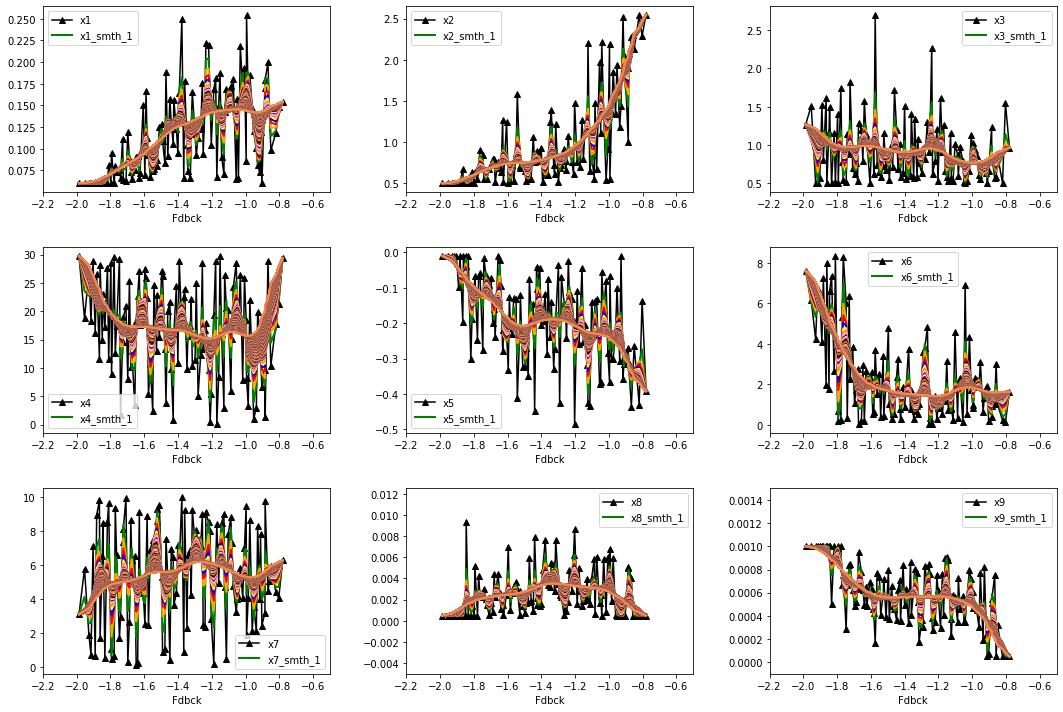

In [89]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Optimization 2

In [162]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.10120333, 0.93524323, 2.30825521, ..., 0.50701769, 0.53470794,
        6.13290286],
       [0.10079103, 0.93577217, 2.26589526, ..., 0.52364937, 0.54339338,
        5.90264943],
       [0.10037987, 0.93606031, 2.22340602, ..., 0.54006491, 0.55198311,
        5.67655372],
       ...,
       [0.26371381, 2.6131736 , 1.20319983, ..., 0.94245303, 0.90823014,
        7.24584382],
       [0.27034395, 2.67740844, 1.17655174, ..., 0.96061773, 0.91737892,
        7.52574227],
       [0.2770102 , 2.74168626, 1.14947666, ..., 0.97897409, 0.92660387,
        7.80768198]])

In [163]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable, eofs_combined, X_rec_obs, 
                      Mean, W_eof_2D, W_rmse_2D)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985956,10.756101
1,-1.953341,10.295523
2,-1.927200,9.839826
3,-1.914980,9.389451
4,-1.902441,8.944875
...,...,...
108,-0.860371,7.570268
109,-0.852741,7.976706
110,-0.820649,8.391057
111,-0.803475,8.811504


In [166]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable, eofs_combined, X_rec_obs, 
                      Mean, W_eof_2D, W_rmse_2D)
#sol_df_2

fun_x0 = 10.756100738395393
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.756100738395393
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 10.295522916269594
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.295522916269594
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 9.839825897831204
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.839825897831204
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 9.389450579499922
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.389450579499922
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 8.944875167136203
Optimization terminated successfu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.317444050315493
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
fun_x0 = 1.2798853544837285
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2798853544837285
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 1.2362951517875849
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2362951517875849
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 1.1979714629095808
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1519554038186097
            Iterations: 12
            Function evaluations: 78
            Gradient evaluations: 8
fun_x0 = 1.1643849960810417
Optimization terminated successfully.    (Exit mode 0)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0778343458596307
            Iterations: 15
            Function evaluations: 111
            Gradient evaluations: 11
fun_x0 = 1.145917410786518
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1480245618870237
            Iterations: 6
            Function evaluations: 56
            Gradient evaluations: 5
fun_x0 = 1.18586616980353
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1472435726869665
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 9
fun_x0 = 1.2303993655372958
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.22485724227589
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 9
fun_x0 = 1.2794364082671057
Optimization terminated successfully.    (Exit mode 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.3549559712589785
            Iterations: 14
            Function evaluations: 100
            Gradient evaluations: 10
fun_x0 = 6.787142166856733
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.787142166856733
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 7.1733055768029015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.161910177330295
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
fun_x0 = 7.570268173911307
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.538215059279481
            Iterations: 8
            Function evaluations: 34
            Gradient evaluations: 4
fun_x0 = 7.976706185659734
Optimization terminated successfully.    (Exit mode 0)
 

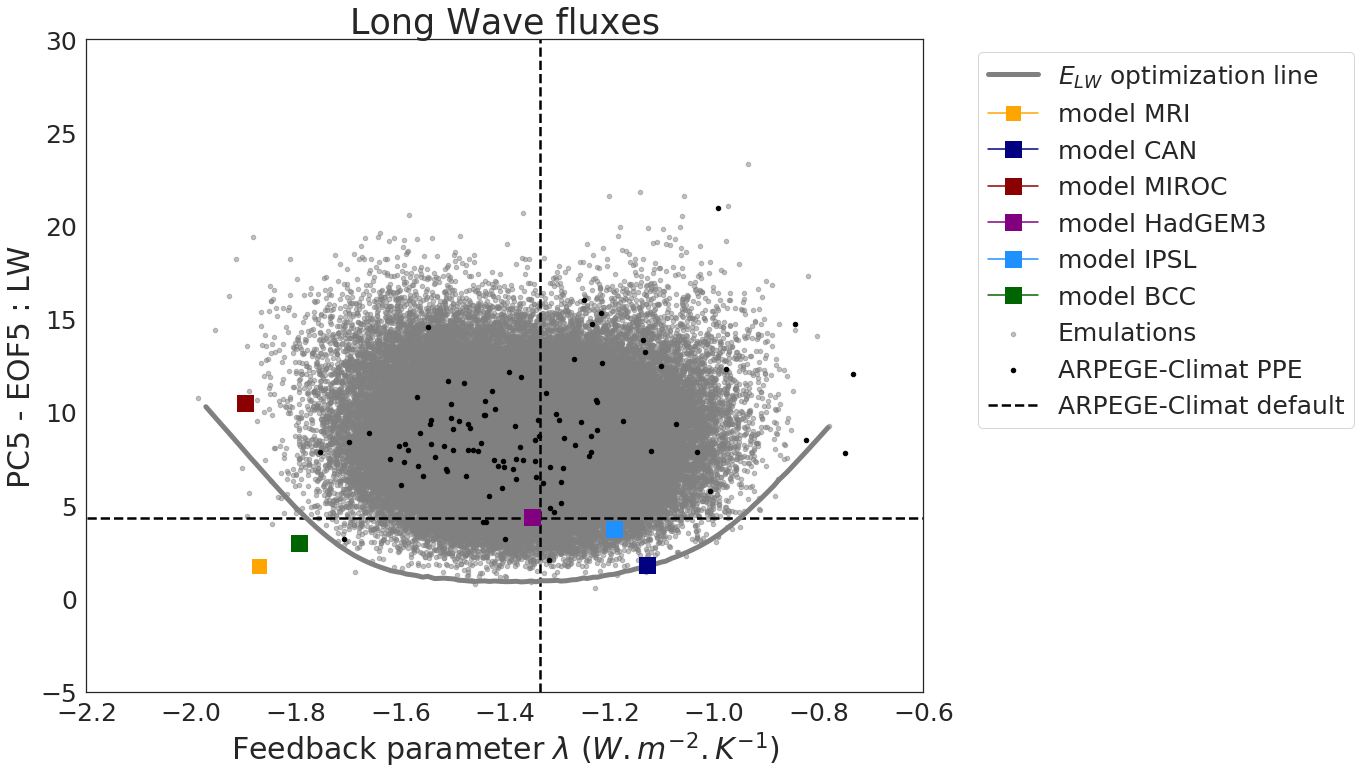

In [168]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.5, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=1.0,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 30.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 50,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{LW}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title(TITLE, fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-5,30)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save data

In [169]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

## Projection of sub-set on EOF basis

### Settings 

In [5]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
product = 'CERES'

In [6]:
nb_p_select = ['p860', 'p861', 'p862', 'p864', 'p865', 'p866', 'p867', 'p868', 'p869', 
                    'p870', 'p871', 'p872', 'p873','p874', 'p875', 'p876', 'p877', 'p878', 'p879',
                    'p880', 'p881', 'p882', 'p883']
len(nb_p_select)

23

In [7]:
N_error=128*256

### Functions

In [8]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_eof_2D, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs, W_rmse_2D)
    return diff

In [9]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_file_npy+"/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [10]:
## --Full function predict PC from x + reconstruct 3D field + compute partial RMSE

def function_RMSE_emulator_std(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 

    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims=2)
    
    U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    pc = U_obs
    nb_dims = 2 
    X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    
    return E

def function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable, eofs_combined, 
                                   X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    return float(E)

### EOF, tas_mean and PCs

In [11]:
# --Mean
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

# --Weights
W_eof_3D = np.load(path_file_npy+'/W_eof_3D_'+variable+'.npy')
W_eof_2D = np.load(path_file_npy+'/W_eof_2D_'+variable+'.npy')
W_rmse_2D = np.load(path_file_npy+'/W_rmse_2D_'+variable+'.npy')

In [12]:
# -- eof_combined 
eofs=[]
for i in range(1,6,1) :
    eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(eof_tmp)
                     
## --Combine the 5 modes for reconstruction
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

## Error estimate in ARPEGE-Climat

In [13]:
E_p1 = np.load(path_file_npy+'/E_p1_'+variable+'.npy')
p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [14]:
# -- X_rec_obs 
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
X_rec_obs = reconstruct_X(eofs_combined, pc=U_obs, nb_dims=2) 

In [15]:
E_df_selection=[]
for i in nb_p_select :
    U_mod = np.load(path_file_npy+'/U_'+i+'_'+variable+'.npy')
    X_rec_mod = reconstruct_X(eofs_combined, pc=U_mod, nb_dims=2)
    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)

    E_df_selection.append(float(E))

#E_df_selection

In [16]:
Fdbck_selection = np.load('/data/home/globc/peatier/CNRMppe/PPE/'+ENSEMBLE+'files/npy/SIX_Net_feedbacks.npy')
Fdbck_selection

array([-1.70182872, -1.64660211, -1.65067859, -1.57314086, -1.60480499,
       -1.59460457, -1.584928  , -1.5537655 , -1.48534687, -1.53561556,
       -1.46918408, -1.40725935, -1.30876013, -1.17850196, -1.11752943,
       -1.07712932, -0.9657925 , -0.9024847 , -0.70984636, -0.59886702,
       -0.64100514, -0.69628074, -0.67599579])

## Error estimate with emulator

In [18]:
file = np.load(path_file_npy+'/RMSE_optim2_select2.npy')
df_select = pd.DataFrame(file).drop([2])
df_select

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,-2.509224,-25.309487,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308
1,1.762048,-1.915792,0.105226,0.946306,2.217400,23.271347,-0.119617,8.326439,3.862775,0.004866,...,-2.699887,-28.735554,0.081387,13.630740,0.000048,0.877644,0.714951,0.584855,0.575630,5.421690
3,1.365314,-1.793117,0.117653,0.925779,1.993968,16.535588,-0.144756,6.979020,4.723136,0.004277,...,-2.879095,-32.476790,0.084603,12.153954,0.000052,0.867025,0.789303,0.687230,0.631255,4.689734
4,1.210276,-1.739799,0.124279,0.914087,1.872786,16.160868,-0.139411,6.202231,4.822008,0.004093,...,-2.861966,-33.377190,0.081028,10.923123,0.000054,0.872076,0.799245,0.704418,0.642916,4.478891
5,1.092965,-1.688818,0.129353,0.916731,1.799238,16.227429,-0.133492,5.376256,4.795431,0.004196,...,-2.800839,-33.904028,0.076146,9.493748,0.000055,0.867365,0.798937,0.710677,0.646475,4.211288
6,1.002655,-1.638441,0.132807,0.937947,1.799551,16.191064,-0.127751,4.593259,4.620000,0.004596,...,-2.694675,-33.900412,0.071569,8.145789,0.000057,0.854647,0.792044,0.718739,0.648308,3.984981
7,0.931638,-1.588352,0.135540,0.988634,1.843533,16.185412,-0.119959,3.950301,4.326672,0.005104,...,-2.559700,-33.503864,0.067906,7.006633,0.000058,0.840374,0.777997,0.731503,0.656286,3.897473
8,0.873728,-1.538515,0.139184,1.073116,1.875451,16.454288,-0.109988,3.473790,4.068607,0.005482,...,-2.448508,-33.084557,0.064489,6.016906,0.000057,0.829561,0.758095,0.742957,0.673381,3.920094
9,0.824222,-1.488119,0.143873,1.170296,1.863909,16.803264,-0.101644,3.133087,3.975235,0.005613,...,-2.393045,-32.867850,0.060039,5.179393,0.000056,0.824722,0.736912,0.749706,0.694522,4.013213
10,0.782407,-1.438072,0.148822,1.243236,1.816102,16.938484,-0.101276,2.907720,4.027534,0.005509,...,-2.373002,-32.887497,0.053725,4.569307,0.000055,0.827338,0.718612,0.754621,0.711067,4.198545


In [19]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
df_optim_total = pd.DataFrame(file)
df_optim_total

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,-2.509224,-25.309487,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308
1,1.934300,-1.971665,0.101923,0.938328,2.290108,28.452721,-0.088391,8.812695,3.234051,0.005073,...,-2.549339,-26.039369,0.076355,14.002736,0.000045,0.903765,0.666056,0.523087,0.543147,5.980319
2,1.890688,-1.957551,0.102680,0.940761,2.272516,27.085657,-0.096932,8.693807,3.398839,0.005022,...,-2.589319,-26.757640,0.077713,13.913016,0.000046,0.896417,0.678766,0.539040,0.551536,5.832291
3,1.847656,-1.943524,0.103436,0.942923,2.254566,25.755345,-0.105087,8.573051,3.560103,0.004973,...,-2.628029,-27.452732,0.079016,13.821948,0.000047,0.889531,0.691275,0.554654,0.559706,5.688266
4,1.804734,-1.929515,0.104246,0.945437,2.235712,24.480462,-0.112664,8.448105,3.717275,0.004923,...,-2.664538,-28.113783,0.080253,13.730112,0.000047,0.883268,0.703476,0.569898,0.567690,5.549150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.677538,-0.835138,0.251033,2.497033,1.288496,23.511310,-0.392016,1.782295,5.319526,0.007066,...,-2.574742,-45.057061,0.018243,7.164023,0.000046,0.571366,0.599374,0.892900,0.885384,6.626445
109,1.778052,-0.822073,0.257232,2.554557,1.254177,24.881865,-0.402303,1.785273,5.539171,0.007239,...,-2.559205,-45.596600,0.018223,7.704046,0.000045,0.560593,0.587080,0.913689,0.894995,6.904529
110,1.884405,-0.808612,0.263653,2.615155,1.219543,26.338284,-0.412717,1.791978,5.772441,0.007417,...,-2.544069,-46.176296,0.018176,8.270878,0.000044,0.549477,0.574530,0.935129,0.905142,7.200580
111,1.972740,-0.797967,0.269891,2.650933,1.176321,27.507121,-0.420415,1.778796,5.940043,0.007548,...,-2.509903,-46.511473,0.018145,8.830086,0.000044,0.540922,0.561021,0.957529,0.910594,7.433596


In [20]:
E_emulator_selection = []
for i in range(0,len(df_select),1) :
    x = df_select.iloc[i][2:]
    E = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    E_emulator_selection.append(E)

E_emulator_selection

[10.754314445654387,
 8.904447443142447,
 5.71786577422133,
 4.634925338725668,
 3.9036260345237217,
 3.3852773801904834,
 3.0290452340779646,
 2.7786569646817907,
 2.5864296514090976,
 2.434660714628397,
 2.3114283634491577,
 2.2260476892049823,
 2.1845656845492525,
 2.186075460218773,
 2.2607083206770704,
 2.422591928353701,
 2.6819910965294946,
 3.1137772825016814,
 3.844473739205647,
 4.972641180762016,
 6.510965358346468,
 8.394465317017413,
 9.151965597967658]

In [21]:
E_optim_total = []
for i in range(0,len(df_optim_total),1) :
    x = df_optim_total.iloc[i][2:]
    E = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    E_optim_total.append(E)
    
#E_optim_total

In [23]:
RMSE_optim_line = np.load(path_file_npy+'/RMSE_optim2_'+variable+'.npy')
Fdbck_optim_line = np.load(path_file_npy+'/Fdbck_optim2_'+variable+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,sol_fun,Fdbck
0,10.756101,10.756101,-1.985956
1,10.295523,10.295523,-1.971744
2,9.839826,9.839826,-1.957583
3,9.389451,9.389451,-1.943522
4,8.917787,8.917787,-1.928571
...,...,...,...
108,7.538215,7.538215,-0.835718
109,7.976706,7.976706,-0.821188
110,8.371441,8.371441,-0.808404
111,8.811504,8.811504,-0.794096


In [24]:
df_optim_total_final= pd.DataFrame(E_optim_total, columns=['RMSE'])
df_optim_total_final['Fdbck']= df_optim_total[1]
df_optim_total_final

,RMSE,Fdbck
0,10.754314,-1.985892
1,10.377604,-1.971665
2,10.004194,-1.957551
3,9.636885,-1.943524
4,9.272043,-1.929515
...,...,...
108,7.612203,-0.835138
109,7.995118,-0.822073
110,8.394465,-0.808612
111,8.733611,-0.797967


In [25]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
PPE_df

,E_PPE,Fdbck
0,8.517303,-0.825236
1,8.872889,-1.659636
2,12.656512,-1.215000
3,11.049263,-1.321641
4,7.824954,-0.750397
...,...,...
97,8.173671,-1.516367
98,7.961097,-1.584491
99,6.553689,-1.474525
100,8.360200,-1.445422


## Plot

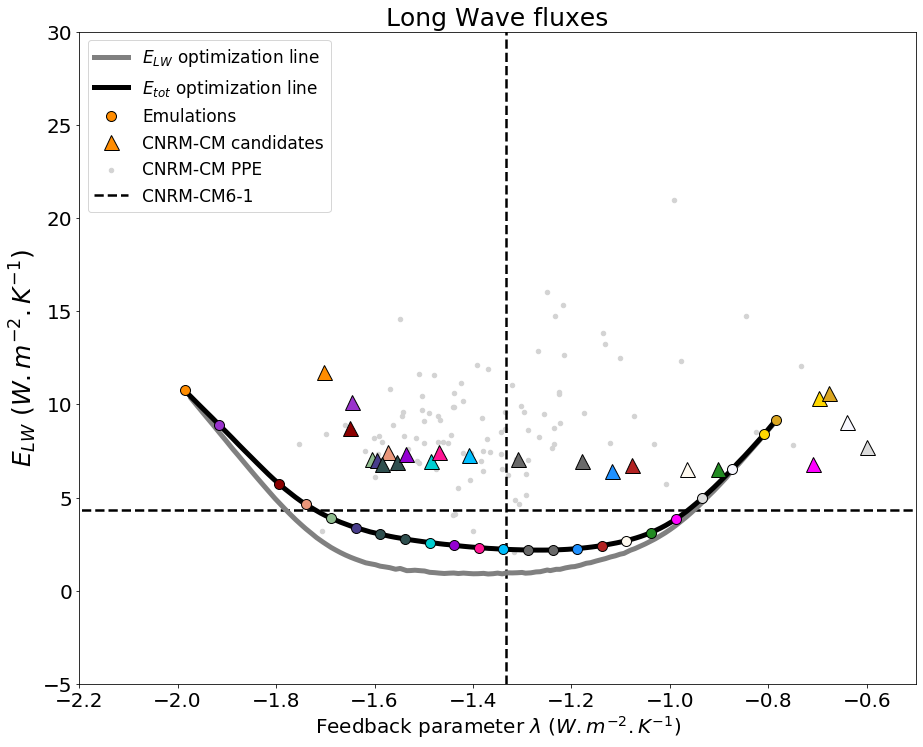

In [26]:
import matplotlib.colors as mcolors
import random

plt_colors = list(mcolors.CSS4_COLORS.keys())
st=30
colors=plt_colors[st:st+23]

cpt=0

ax = plt.gca()

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, 
                  linewidth=5, figsize=(15, 12), ax = ax)

df_optim_total_final.plot(kind='line', x='Fdbck', y='RMSE', color='black', alpha=1, 
                          linewidth=5, ax=ax)


PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='lightgray', 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 50,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

for i in colors :
    if cpt == 0 :
        ax.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], 
                 markerfacecolor=i, color='black',  
                 marker='o', linewidth=0, markersize=10, zorder=8)

        ax.plot(Fdbck_selection[cpt], E_df_selection[cpt], 
                 markerfacecolor=i, color='black',  
                 marker='^', linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        ax.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], 
                 markerfacecolor=i, color='black', 
                 marker='o', linewidth=0, markersize=10, label='_nolegend_')

        ax.plot(Fdbck_selection[cpt], E_df_selection[cpt], 
                 markerfacecolor=i, color='black', 
                 marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = [ '$E_{LW}$ optimization line','$E_{tot}$ optimization line', 'Emulations',
          'CNRM-CM candidates', 'CNRM-CM PPE', 'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=17) #bbox_to_anchor=(1.05, 1)

plt.title(TITLE, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-5,30)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_selection.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [27]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/E_selection_'+variable+'.npy', E_df_selection)

### [Back to the top](#top)

# <a id="correl">Check correlation with simple RMSE</a> </li> 

## Get the data 

In [42]:
# PPE amip simulations 
filename='*_amip_*.nc'


amip={}

for nb_p in nb_p_list :
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_LW_xarr(path, filename, variables)
    

In [43]:
nb_p_select = ['p840', 'p841', 'p842', 'p843','p844', 'p845', 'p846', 'p847']

amip_select={}

for nb_p in nb_p_select :
    path=path_PPE+'ENSEMBLE4_selection/CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    tmp = get_3D_LW_xarr(path, filename, variables)
    amip_select[str(nb_p)] = tmp.assign_coords(lat=amip_list[0]['lat'])
    

In [44]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs[variable] =  df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

In [45]:
# Reference p1
diff = (amip['p1'].values - obs[variable_obs].values)**2
diff_p1 = sqrt(sum(diff)/(128*256))
diff_p1

KeyError: 'p1'

In [47]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    mod = amip[p]*df_W
    observation = obs[variable]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))

In [48]:
df_fig = pd.DataFrame(E_PPE, columns=['E_tas'])
df_fig['RMSE'] = ej_list
df_fig

,E_tas,RMSE
0,6.809218,8.803616
1,7.093494,8.873039
2,10.118338,11.201629
3,8.833412,10.091347
4,6.255715,8.215169
...,...,...
97,6.534499,8.521762
98,6.364555,8.639256
99,5.239393,7.901287
100,6.683621,8.633709


In [49]:
r = np.corrcoef(df_fig['E_tas'], df_fig['RMSE'])
r

array([[1.        , 0.98371325],
       [0.98371325, 1.        ]])

In [54]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_select :
    mod = amip_select[p]*df_W
    observation = obs[variable]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))
    
df_fig_select = pd.DataFrame(E_df_selection, columns=['E_tas'])
df_fig_select['RMSE'] = ej_list
df_fig_select

,E_tas,RMSE
0,6.313313,8.197197
1,6.610591,8.373647
2,5.506089,7.555197
3,5.446166,7.222423
4,5.540701,7.550869
5,5.055891,7.371560
6,4.935113,7.515575
7,7.535455,9.745593


In [55]:
r = np.corrcoef(df_fig_select['E_tas'], df_fig_select['RMSE'])
r

array([[1.        , 0.94756161],
       [0.94756161, 1.        ]])

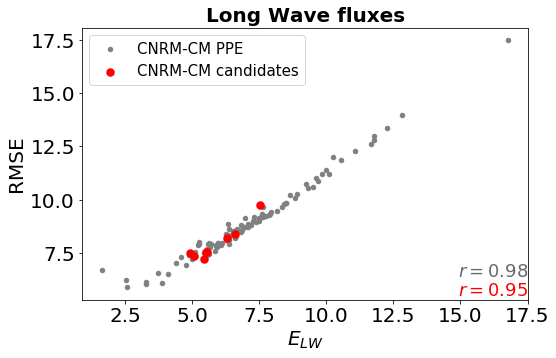

In [57]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', y='RMSE', x='E_tas', color = 'gray', alpha=1, ax=ax)
df_fig_select.plot(kind='scatter', y='RMSE', x='E_tas', color = 'red', linewidth=4, alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('$E_{LW}$', size = 20)
ax.set_ylabel('RMSE', size = 20)
ax.set_title('Long Wave fluxes', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.07,r'$r = 0.98$',horizontalalignment='right',color='dimgray',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.0,r'$r = 0.95$',horizontalalignment='right', color='red',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

#plt.xlim([0.0, 2.0])
#plt.ylim([0.0, 2.0])

# Legend .................

legend = [ 'CNRM-CM PPE', 'CNRM-CM candidates']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)